In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
matplotlib.style.use('ggplot')

In [2]:
AdSmartABdata = pd.read_csv("AdSmartABdata.csv") 

In [3]:
AdSmartABdata.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
pltbar = AdSmartABdata.groupby(['experiment','yes','no']).size()
pltbar

experiment  yes  no
control     0    0     3485
                 1      322
            1    0      264
exposed     0    0     3349
                 1      349
            1    0      308
dtype: int64

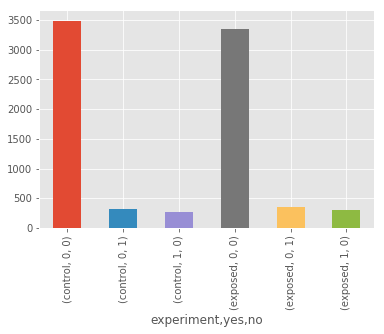

In [5]:
pltbar.plot.bar()

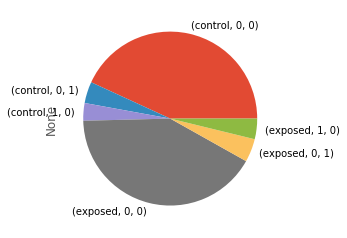

In [99]:
pltbar.plot.pie()

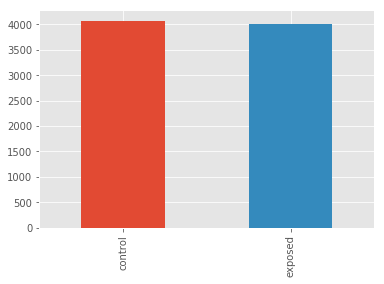

In [89]:
AdSmartABdata['experiment'].value_counts().plot.bar()

## Task 2.1 Perform Classical and sequential A/B testing

In [ ]:
# Firstly let know the the impression and the conversion rate of the two ads 
# Secondly due to the changes we made, we would love know if there is atleast 2% increase in the awareness rate  

In [35]:
#importing neccesary libraries
import statsmodels.api as sm
import scipy.stats as scs
from scipy.stats import norm

In [11]:
bio_data = AdSmartABdata[np.logical_or(AdSmartABdata['yes']==1,AdSmartABdata['no']==1)]

In [19]:
# Creating a new table to contain the impression and the conversion rate
# the conversion rate is the number of people that knows the brand over the total know of people that RESPONEDED
# to the BIO i.e yes/impression per exp(yes or no)
bio_data_table = bio_data.pivot_table(values='yes', index='experiment',aggfunc = np.sum)
bio_data_table['impression per exp(yes and no)'] = bio_data.pivot_table(values='yes',index='experiment',aggfunc=lambda x:len(x))
bio_data_table['conversion rate'] = bio_data.pivot_table(values='yes',index='experiment')

In [20]:
bio_data_table

,yes,impression per exp(yes and no),conversion rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [22]:
# the actual conversion rate is the differience in the conversion rate of the exposed and control
control_yes = bio_data_table['yes'][0]
control_imp = bio_data_table['impression per exp(yes and no)'][0]
control_conv = bio_data_table['conversion rate'][0]

exposed_yes = bio_data_table['yes'][1]
exposed_imp = bio_data_table['impression per exp(yes and no)'][1]
exposed_conv = bio_data_table['conversion rate'][1]

conv_rate_diff = exposed_conv - control_conv

In [23]:
conv_rate_diff

0.018285619295484168

In [ ]:
## Though there is PROBABLY an increase in the conversion rate of 0.18 but it is not up to our expectation i.e 2%(0.02) and this is not enough evidence 
# we cant totaly 

In [ ]:
## Let measure our confident level by comparing the distribution of the two groups (Exposed and Control)

Text(0, 0.5, 'probability')

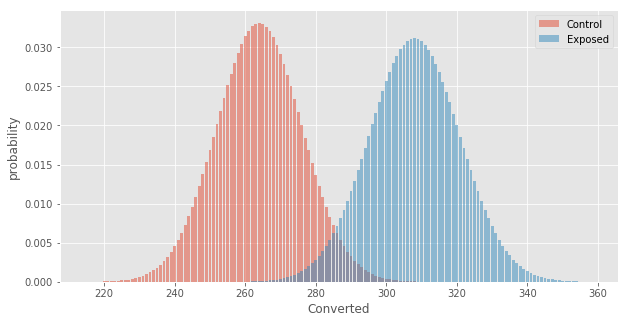

In [153]:
#Using Binomial distribution we can do some estimation using our sample to calculate the probability of getting the result
#from our test groups

x_control = np.linspace(control_yes-49, control_yes+50, 100)
x_exposed = np.linspace(exposed_yes-49, exposed_yes+50, 100)

# probaility of having a yes in  control and exposed
y_control = scs.binom(control_imp, control_conv).pmf(x_control)
y_exposed = scs.binom(exposed_imp, exposed_conv).pmf(x_exposed)

#Ploting the bar plots
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x_control, y_control, label = "Control",alpha=0.5)
ax.bar(x_exposed, y_exposed, label = "Exposed",alpha=0.5)
plt.legend()
plt.xlabel('Converted')
plt.ylabel('probability')

Text(0, 0.5, 'probablity')

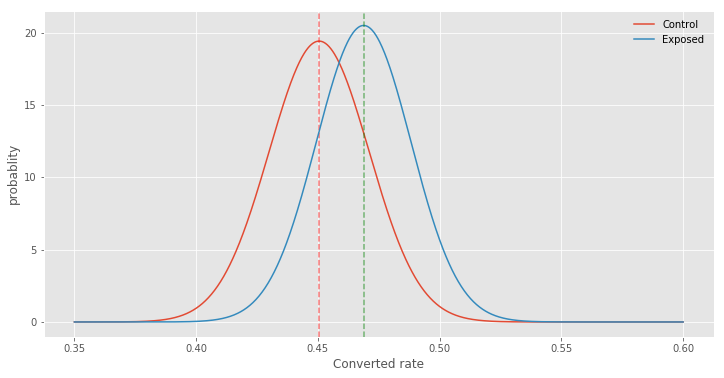

In [158]:
# We can get average conversion pf each group ,this averaging of the distribution means our final estimate will be well
#approximated by normal distribution
#So using the normal approximation here ...
std_control = np.sqrt(control_conv * (1-control_conv)) / np.sqrt(control_imp)
std_exposed = np.sqrt(exposed_conv * (1-exposed_conv)) / np.sqrt(exposed_imp)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(.35, .60, 1000)

y_control = scs.norm(control_conv, std_control).pdf(x)
y_exposed = scs.norm(exposed_conv, std_exposed).pdf(x)

#Ploting Bar plot
ax.plot(x, y_control,label = "Control")
ax.axvline(x=control_conv, c='red', alpha=0.5, linestyle='--')
ax.plot(x, y_exposed,label = "Exposed")
ax.axvline(x=exposed_conv, c='green', alpha=0.5, linestyle='--')

plt.legend(frameon=False)
plt.xlabel('Converted rate')
plt.ylabel('probablity')

In [159]:
## The difference between the green and red line is conversion rate ... is it Significant yet ?

In [ ]:
# To answer thw question above we need to utilized the fact that the difference of normally distributed random numbers is also 
# a normal
#Let get the z-score,and the p-value then make a proper distribution plot

zscore is 0.646, with p-value 0.259


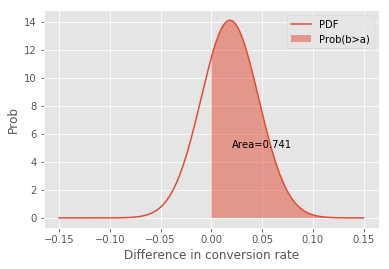

In [160]:
z_score = (conv_rate_diff) / np.sqrt(std_C**2 + std_E**2)
p = norm(conv_rate_diff, np.sqrt(std_C**2 + std_E**2))

x = np.linspace(-0.15, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.5)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

In [ ]:
# So far using our classical aprroach we could say that the null hypothesis is true we would expect to get this result or 
#a result more extreme only 25.9% of the time. As that is a significant  result , we wont reject the null hypothesis and 
# state that we have evidence that exposed group > control group 
# Though this is a one-tail-test
#An alternative is the two-tailed-test where we just discriminate that exposed is different from control .  in that case ,
#our p-value is actually 2 X 25.9= 51.8% and we want more sample before rejecting the null hypothesis if we stick to the 
#p-value of 0.05 threshold

In [40]:
def get_confidence_ab_test(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

def get_p_value(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.sf(z_score)

In [41]:
print(get_confidence_ab_test(control_yes, control_imp, exposed_yes, exposed_imp))

0.7408273254172715


In [43]:
print("P-value =",get_p_value(control_yes, control_imp, exposed_yes, exposed_imp))

P-value = 0.2591726745827285


In [44]:
n = 10000
rates_a = norm(control_conv, std_C).rvs(n)
rates_b = norm(exposed_conv, std_E).rvs(n)
b_better = (rates_b > rates_a).sum() / n
print(f"exposed is better than control {b_better * 100:0.1f}% of the time")

exposed is better than control 74.1% of the time


In [46]:
a_dist = np.zeros(control_imp)
a_dist[:control_yes] = 1
b_dist = np.zeros(exposed_imp)
b_dist[:exposed_yes] = 1
zscore, prob = scs.ttest_ind(a_dist, b_dist, equal_var=True)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.65, p-value is 0.519 (two tailed), 0.259 (one tailed)


In [47]:
sm.stats.ztest(b_dist,a_dist,alternative="larger")

(0.6452687398426953, 0.2593765234051756)

## Using Welsch's t-test

In [48]:
from scipy.stats import ttest_ind
a_dist = np.zeros(control_imp)
a_dist[:control_yes] = 1
b_dist = np.zeros(exposed_imp)
b_dist[:exposed_yes] = 1
zscore, prob = ttest_ind(a_dist, b_dist, equal_var=False)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.65, p-value is 0.519 (two tailed), 0.259 (one tailed)


In [49]:
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(0.8)
Z_alpha = standard_norm.ppf(1-0.05/2)
pooled_prob = (control_conv + control_conv+conv_rate_diff) / 2
min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / conv_rate_diff**2)

In [50]:
print(min_N)

11660.61386940473


In [ ]:
## This shows that we need more samples even well optimization

## Task 2.2 Machine Learning

In [52]:
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
#!pip install xgboost
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [65]:
bio_data_1 = bio_data

In [72]:
bio_data_1.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2020-07-05,2,4,1,2,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,1,2020-07-04,16,13,1,1,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,1,2020-07-06,8,13,1,1,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,0,2020-07-08,4,43,1,4,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,0,2020-07-03,15,13,1,1,0,1


In [71]:
label_encoder = preprocessing.LabelEncoder()  
bio_data_1['experiment']= label_encoder.fit_transform(bio_data_1['experiment'])
bio_data_1['platform_os']= label_encoder.fit_transform(bio_data_1['platform_os'])
bio_data_1['device_make']= label_encoder.fit_transform(bio_data_1['device_make'])
bio_data_1['browser']= label_encoder.fit_transform(bio_data_1['browser'])

C:\Users\UNION\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\UNION\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\UNION\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [73]:
train, validate, test = np.split(bio_data_1.sample(frac=1), [int(.7*len(bio_data_1)), int(.9*len(bio_data_1))])

In [115]:
X_train = train[['experiment', 'device_make', 'platform_os', 'browser']]
Y_train = train['yes']

X_valid = validate[['experiment',  'device_make', 'platform_os', 'browser']]
Y_valid = validate['yes']

X_test = test[['experiment', 'device_make', 'platform_os', 'browser']]
Y_test  = test['yes'] 



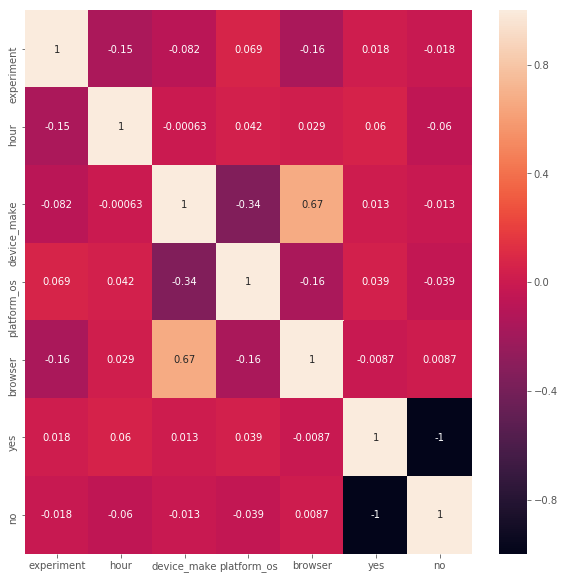

In [77]:
corr_mat = bio_data_1.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
g = sns.heatmap(bio_data[top_corr_features].corr(), annot= True)

In [78]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

##  Logistic Regression

In [139]:
log_model = LogisticRegression()
print(cross_val_score(log_model, X_train, Y_train,cv=k_fold, scoring= 'accuracy'))

C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.54022989 0.57471264 0.52298851 0.56896552 0.48850575]


C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [140]:
log_model.fit(X_train,Y_train,)

C:\Users\UNION\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [141]:
log_model.score(X = X_train ,y = Y_train)

0.539080459770115

## Decision Tree

In [126]:
regressor = DecisionTreeClassifier()
print(cross_val_score(regressor, X_train, Y_train,cv= k_fold, scoring= 'accuracy'))

[0.54597701 0.56896552 0.52873563 0.55172414 0.50574713]


In [127]:
regressor.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

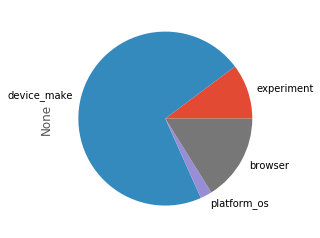

In [128]:
feat_importance = pd.Series(regressor.feature_importances_, index=X_train.columns)
feat_importance.plot(kind='pie')

In [130]:
y_pred = regressor.predict(X_valid)
df=pd.DataFrame({'Actual':Y_valid, 'Predicted':y_pred})
df.head()

,Actual,Predicted
6752,1,0
2521,0,0
7837,0,0
4142,0,0
823,1,0


## Xgboost

In [131]:
data_dmatrix = xgb.DMatrix(data=train_invar,label=train_targ)
xg_reg = xgb.XGBClassifier()#objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
               # max_depth = 5, alpha = 10, n_estimators = 10)
print(cross_val_score(xg_reg, X_train, Y_train,cv= k_fold, scoring= 'accuracy'))

[0.55172414 0.60344828 0.54022989 0.55747126 0.54022989]


In [132]:
xg_reg.fit(X_train,Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

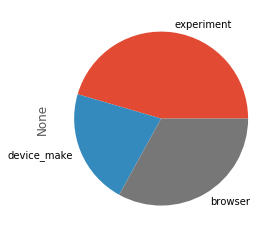

In [133]:
feat_importance = pd.Series(xg_reg.feature_importances_, index=X_train.columns)
feat_importance.plot(kind='pie')

In [87]:
prediction = xg_reg.predict(X_valid)

In [ ]:
##

In [134]:
df1=pd.DataFrame({'Actual':Y_valid, 'Predicted':prediction})
df1.head()

,Actual,Predicted
6752,1,0
2521,0,0
7837,0,0
4142,0,0
823,1,0


In [135]:
pred = prediction == np.array(Y_valid)


In [136]:
count = 0
for i in pred:
    if i==True:
        count+=1
print(count)

133


In [137]:
accuracy_perc = count/len(pred) *100

In [138]:
accuracy_perc

53.62903225806451